<a href="https://www.kaggle.com/code/aisuko/image-classification-with-customise-model?scriptVersionId=166304304" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Overview

We will create a customise neural network with PyTorch to do the image classification tasks. First, we download the data and move them to the specific folders.


# Loading Data and Visualization Images


In [1]:
%%capture
!unzip /kaggle/input/dogs-vs-cats/train.zip -d /kaggle/working
!unzip /kaggle/input/dogs-vs-cats/test1.zip -d /kaggle/working

In [2]:
import os

def data_status():
    for d_path, d_name, filenames in os.walk('/kaggle/working'):
        print(f"There are {len(d_name)} directories and {len(filenames)} images in '{d_path}'.")
data_status()


train_files=os.listdir('/kaggle/working/train')
test_files=os.listdir('/kaggle/working/test1')

There are 2 directories and 1 images in '/kaggle/working'.
There are 0 directories and 25000 images in '/kaggle/working/train'.
There are 0 directories and 12500 images in '/kaggle/working/test1'.


In [3]:
import torchvision
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision import transforms
from PIL import Image

class CatDogDataset(Dataset):
    def __init__(self, file_list, dir, mode='train', transform = None):
        self.file_list = file_list
        self.dir = dir
        self.mode= mode
        self.transform = transform
        if self.mode == 'train':
            if 'dog' in self.file_list[0]:
                self.label = 1
            else:
                self.label = 0
            
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):
        img = Image.open(os.path.join(self.dir, self.file_list[idx]))
        if self.transform:
            img = self.transform(img)
        if self.mode == 'train':
            img = img.numpy()
            return img.astype('float32'), self.label
        else:
            img = img.numpy()
            return img.astype('float32'), self.file_list[idx]

        
        
batch_size=32

train_transforms=transforms.Compose([
    transforms.RandomRotation(30),
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5],[0.5])
])


cat_files=[tf for tf in train_files if 'cat' in tf]
dog_files=[tf for tf in train_files if 'dog' in tf]

cats=CatDogDataset(cat_files, '/kaggle/working/train', transform=train_transforms)

dogs=CatDogDataset(dog_files, '/kaggle/working/train', transform=train_transforms)

catdogs=ConcatDataset([cats, dogs])

dataloader=DataLoader(catdogs, batch_size, shuffle=True, num_workers=4)

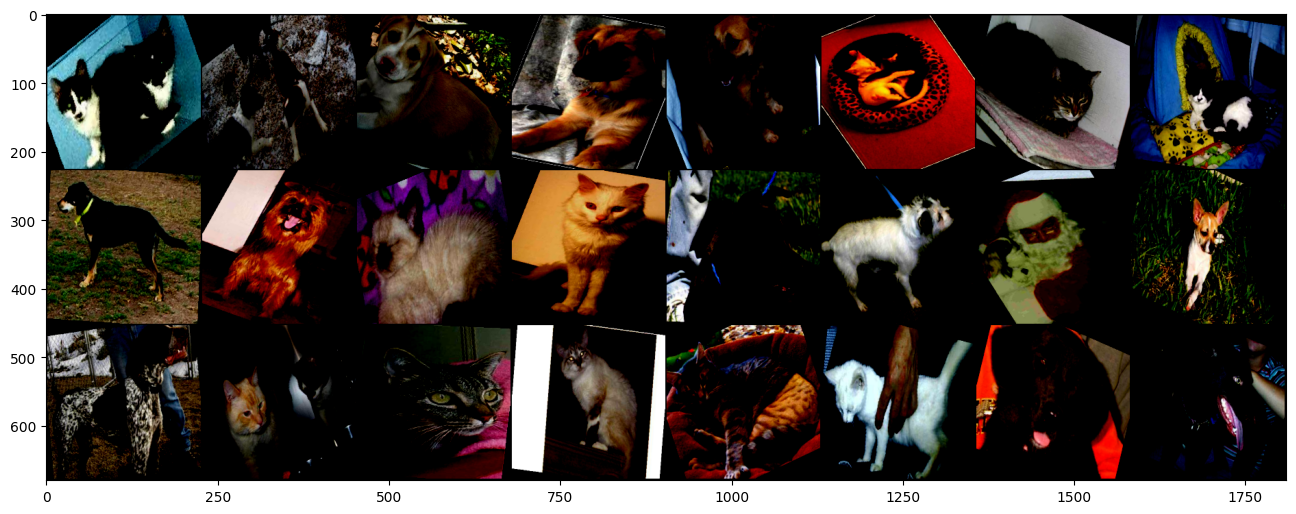

In [4]:
import matplotlib.pyplot as plt
import numpy as np

images, labels = next(iter(dataloader))
plt.figure(figsize=(16,24))
grid_imgs=torchvision.utils.make_grid(images[:24])
np_grid_imgs=grid_imgs.numpy()
plt.imshow(np.transpose(np_grid_imgs, (1,2,0)))

# Define the Model

In [5]:
import torch
import torch.nn as nn

torch.backends.cudnn.deterministic=True

class ImageClassifier(nn.Module):
    def __init__(self):
        super(ImageClassifier, self).__init__()
        
        # define convolutional layers
        
        self.conv1=nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.relu1=nn.ReLU()
        self.pool1=nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2=nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.relu2=nn.ReLU()
        # Since the pooling layer halves the size, the input image width and height must be divisible by 4 to avoid information loss during pooling. So our image should 224x224
        self.pool2=nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Define fully connected layers
        self.fc1=nn.Linear(128*56*56,512) #Adjust the input size based on the image dimensions
        self.relu3=nn.ReLU()
        self.fc2=nn.Linear(512,2) # 2 output
    
    def forward(self, x):
        out=self.conv1(x)
        out=self.relu1(out)
        out=self.pool1(out)
        
        out=self.conv2(out)
        out=self.relu2(out)
        out=self.pool2(out)
        out=out.view(out.size(0), -1) # flatten the output
        
        out=self.fc1(out)
        out=self.relu3(out)
        out=self.fc2(out)
        return out

classifier=ImageClassifier()

device='cuda'
classifier.to(device)

ImageClassifier(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=401408, out_features=512, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)

# Optimizing the Model Parameters

We need loss function and optimizer to train the model.

In [6]:
loss_fn=nn.CrossEntropyLoss()

learning_rate=1e-3
optimizer=torch.optim.SGD(classifier.parameters(), lr=learning_rate)
scheduler=torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[500, 1000, 1500], gamma=0.5)

# Training

Epoch 1
-------------------
Batch 0 -> loss: 0.692205 [    0/25000], Accuracy: 0.468750
Batch 100 -> loss: 0.693280 [ 3200/25000], Accuracy: 0.531250
Batch 200 -> loss: 0.645957 [ 6400/25000], Accuracy: 0.687500
Batch 300 -> loss: 0.689538 [ 9600/25000], Accuracy: 0.562500
Batch 400 -> loss: 0.652757 [12800/25000], Accuracy: 0.593750
Batch 500 -> loss: 0.725990 [16000/25000], Accuracy: 0.562500
Batch 600 -> loss: 0.633653 [19200/25000], Accuracy: 0.718750
Batch 700 -> loss: 0.684294 [22400/25000], Accuracy: 0.593750
Testing Score:
 Accuracy: 62.6%, Avg loss: 0.020390

Epoch 2
-------------------
Batch 0 -> loss: 0.660595 [    0/25000], Accuracy: 0.562500
Batch 100 -> loss: 0.663005 [ 3200/25000], Accuracy: 0.593750
Batch 200 -> loss: 0.654969 [ 6400/25000], Accuracy: 0.687500
Batch 300 -> loss: 0.654434 [ 9600/25000], Accuracy: 0.656250
Batch 400 -> loss: 0.656223 [12800/25000], Accuracy: 0.593750
Batch 500 -> loss: 0.644336 [16000/25000], Accuracy: 0.687500
Batch 600 -> loss: 0.710258

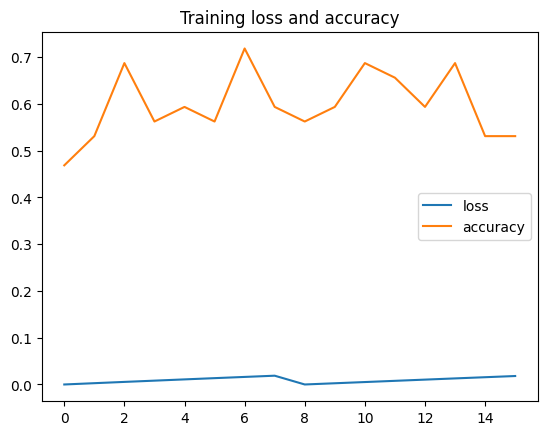

In [7]:
def train_func(dataloader, model, loss_fn, optimizer):
    total_loss=0
    size=len(dataloader.dataset)
    model.train()
    for batch, (X,y) in enumerate(dataloader):
        X,y=X.to(device), y.to(device)
        
        # compute prediction error
        pred=model(X)
        loss=loss_fn(pred,y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss+=loss.item()
        scheduler.step()
        
        if batch %100==0:
            p=torch.argmax(pred, dim=1)
            correct=p.eq(y)
            acc=torch.mean(correct.float()).cpu()
            loss,current=loss.item(), batch*len(X)
            
            print(f'Batch {batch} -> loss: {loss:>7f} [{current:>5d}/{size:>5d}], Accuracy: {acc:>3f}')
            loss_list.append(total_loss/size)
            acc_list.append(acc)
            
            
def test_func(dataloader, model):
    size=len(dataloader.dataset)
    model.eval()
    test_loss, correct=0,0
    with torch.no_grad():
        for X, y in dataloader:
            X,y =X.to(device), y.to(device)
            pred=model(X)
            test_loss+=loss_fn(pred,y).item()
            correct+=(pred.argmax(1)==y).type(torch.float).sum().item()
    test_loss/=size
    correct /=size
    print(f'Testing Score:\n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}\n')
            
epochs=2
loss_list=[]
acc_list=[]

for t in range(epochs):
    print(f'Epoch {t+1}\n-------------------')
    train_func(dataloader, classifier, loss_fn, optimizer)
    test_func(dataloader, classifier)
print("Done")

plt.plot(loss_list, label='loss')
plt.plot(acc_list, label='accuracy')
plt.legend()
plt.title('Training loss and accuracy')
plt.show()

# Save Models

In [8]:
torch.save(classifier.state_dict(), "image_classifier_v01.pth")

# Inference and Submission

In [9]:
test_transforms=transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
#     transforms.Normalize([0.5],[0.5])
])

testset=CatDogDataset(test_files, '/kaggle/working/test1', mode='test', transform=test_transforms)
testloader=DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=4)

In [10]:
import pandas as pd

classifier.eval()
fn_list=[]
pred_list=[]
for x, fn in testloader:
    with torch.no_grad():
        x = x.to(device)
        output = classifier(x)
        pred = torch.argmax(output, dim=1)
        fn_list += [n[:-4] for n in fn]
        pred_list += [p.item() for p in pred]

submission = pd.DataFrame({"id":fn_list, "label":pred_list})
submission.to_csv('preds_with_customize_nn.csv', index=False)

# Checking the Accuracy by Random Images

Note: We can create training epochs in increase the accuracy of the classifier(model).

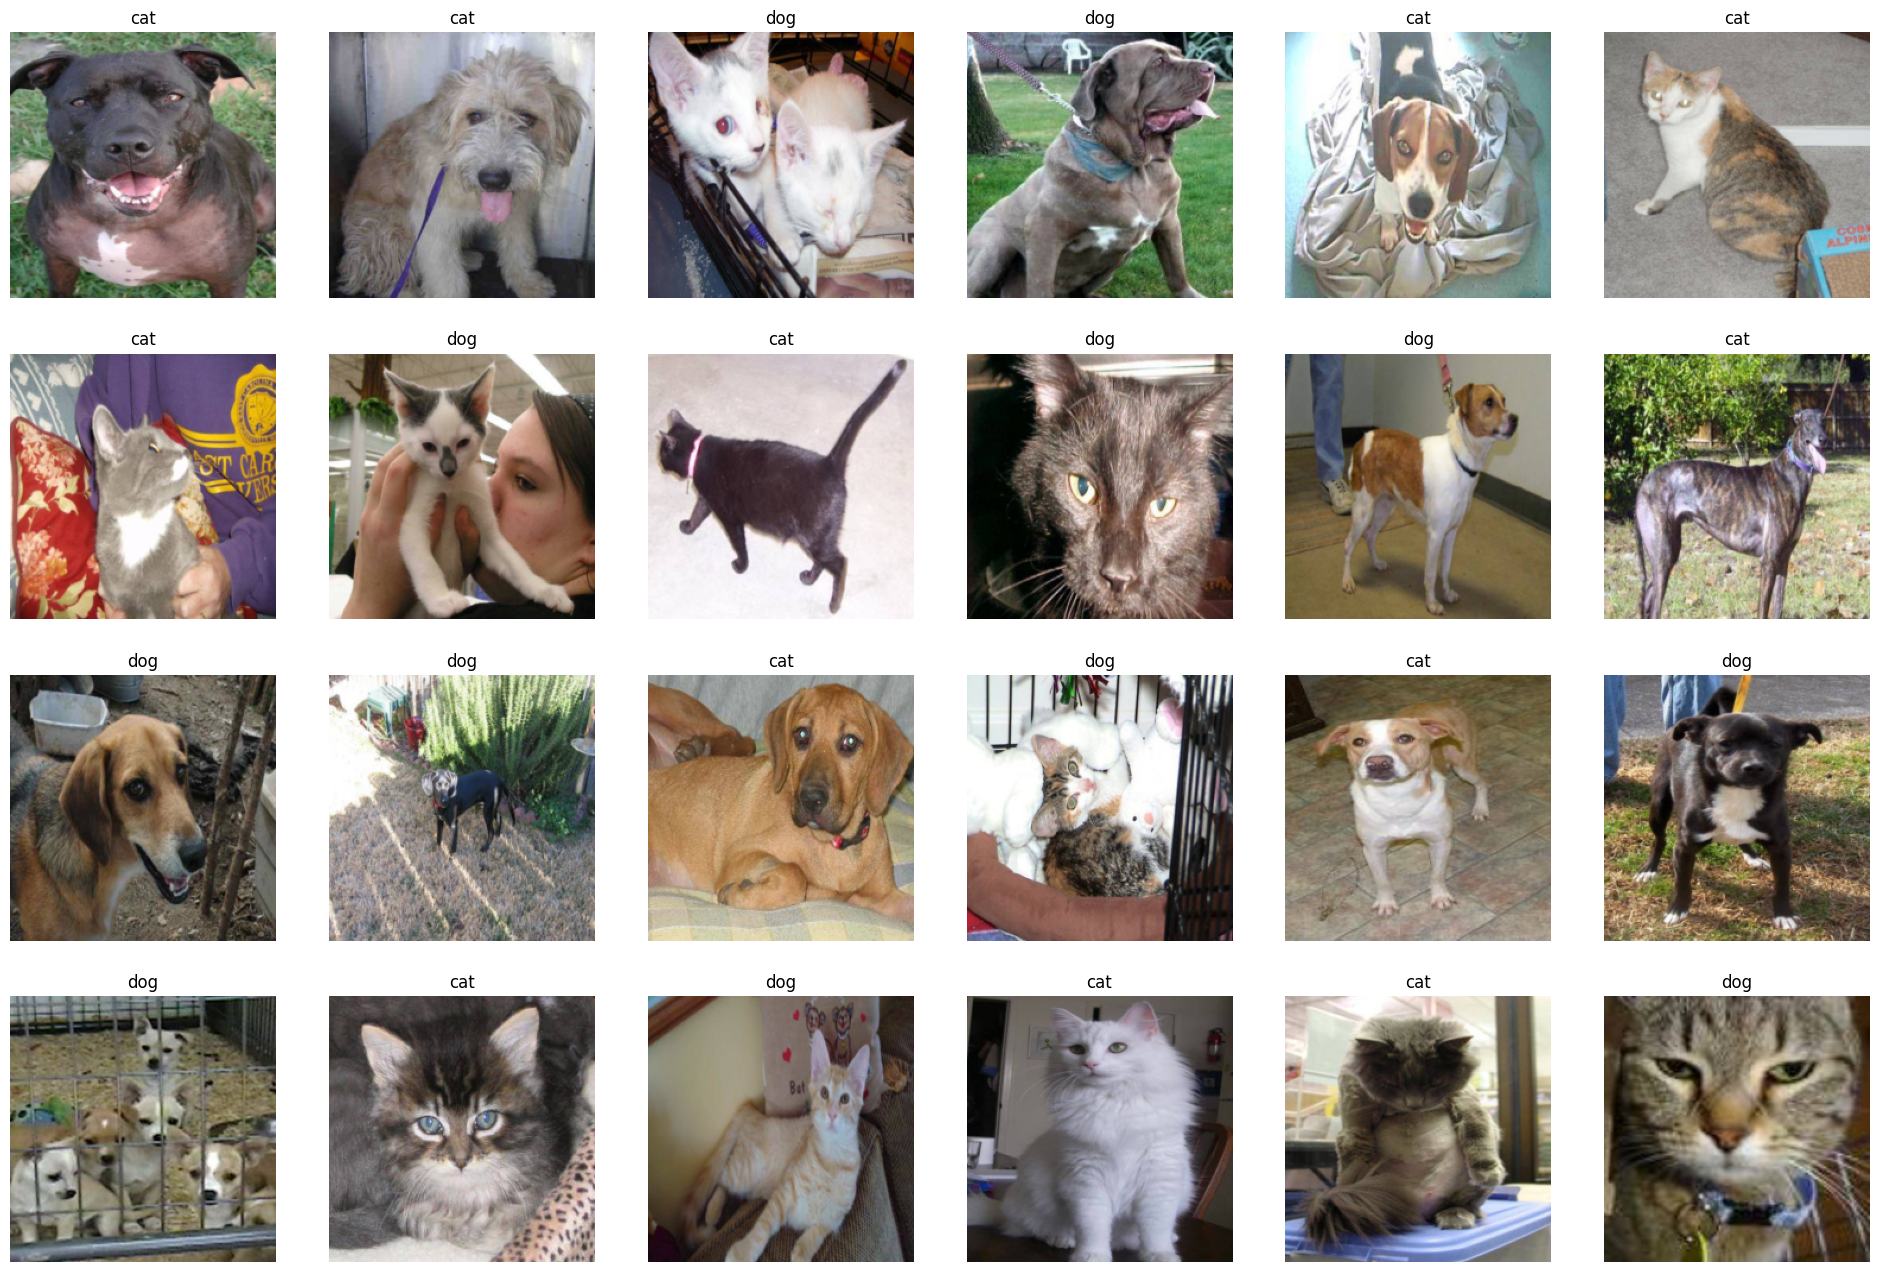

In [11]:
samples, _ =next(iter(testloader))

samples=samples.to(device)
fig=plt.figure(figsize=(24,16))
fig.tight_layout()
output=classifier(samples[:24])
pred=torch.argmax(output, dim=1)
pred=[p.item() for p in pred]
ad={0:'cat', 1:'dog'}

for num, sample in enumerate(samples[:24]):
    plt.subplot(4,6,num+1)
    plt.title(ad[pred[num]])
    plt.axis('off')
    sample=sample.cpu().numpy()
    plt.imshow(np.transpose(sample, (1,2,0)))

# Acknowledge

* https://www.kaggle.com/code/kurniazulda/cat-vs-dog
* https://www.kaggle.com/code/aisuko/fine-tuning-phi-2-with-qlora
* https://www.kaggle.com/code/aisuko/neural-network-for-image-classification
* https://www.kaggle.com/code/jaeboklee/pytorch-cat-vs-dog/notebook